In [2]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

path = 'C:\\Users\\moham\\Desktop\\Third Year Project\\Dataset\\'

columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']


# y82_test = pd.read_csv(path+'y82_testing.csv', header=None)
# y82_train = pd.read_csv(path+'y82_training.csv', header=None)
# L_test = pd.read_csv(path+'L_testing.csv', header=None)
# L_train = pd.read_csv(path+'y82_training.csv', header=None)

# df_train = pd.concat([y82_train, L_train])
# df_test = pd.concat([y82_test, L_test])

# df_train.columns = columns
# df_test.columns = columns


# # factorize 
# df_train['class'], classes = pd.factorize(df_train['class'])
# df_test['class'], classes = pd.factorize(df_test['class'])

# classes = list(classes)
# df_test



y82_test = pd.read_csv(path+'y82_testing.csv', header=None)
y82_train = pd.read_csv(path+'y82_training.csv', header=None)
L_test = pd.read_csv(path+'L_testing.csv', header=None)
L_train = pd.read_csv(path+'y82_training.csv', header=None)

df = pd.concat([y82_train, y82_test, L_test, L_train])

df.columns = columns

df['class'], classes = pd.factorize(df['class'])
classes = list(classes)

X = df.drop('class', axis=1)
y = df['class']


# HYPER PARAM SEARCHING FOR RANDOM FORESTS
### Kinda slow

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

max_estimators = 10
max_depth = 10 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators' : np.arange(1, 10),
              'max_depth' : np.arange(1, 10),
            }


forest_classifier_gscv = GridSearchCV(forest_classifier, param_grid, cv=5)

#fit model to data
forest_classifier_gscv.fit(X_train, y_train)

forest_classifier_gscv.best_params_


10


In [80]:
print(f'Best Params: {forest_classifier_gscv.best_params_} ~ Best Score: {forest_classifier_gscv.best_score_}\n')

pred = forest_classifier_gscv.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, pred))

print(f'\n{list(zip(classes, range(5)))}\n')

print(classification_report(y_test, pred))

print(accuracy_score(y_test, pred))

Best Params: {'max_depth': 8, 'n_estimators': 9} ~ Best Score: 0.941556751641332

[[ 97   1   0   3   2]
 [  1 107   0   3   0]
 [  0   0 104   3   0]
 [  3   1   1  57   0]
 [  0   0   0   0  15]]

[('Chair', 0), ('DownDog', 1), ('Tree', 2), ('WarriorIII', 3), ('Cobra', 4)]

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       103
           1       0.98      0.96      0.97       111
           2       0.99      0.97      0.98       107
           3       0.86      0.92      0.89        62
           4       0.88      1.00      0.94        15

    accuracy                           0.95       398
   macro avg       0.94      0.96      0.95       398
weighted avg       0.96      0.95      0.96       398

0.9547738693467337


In [81]:
max_depth = forest_classifier_gscv.best_params_['max_depth']
n_estimators = forest_classifier_gscv.best_params_['n_estimators']

best_forest = RandomForestClassifier(max_depth = max_depth, n_estimators=n_estimators)
best_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=9)

# This takes ages, it's generating a whole image 

In [83]:
from sklearn import tree
def generate_tree():
    fn=columns
    cn=classes
    fig, axes = plt.subplots(nrows = 1, ncols = best_forest.n_estimators, figsize = (10,6), dpi=900)

    for tree_idx in range(best_forest.n_estimators):
        tree.plot_tree(best_forest.estimators_[tree_idx],
                    feature_names = fn, 
                    class_names=cn,
                    filled = True,
                    ax = axes[tree_idx]);
        axes[tree_idx].set_title('Estimator: ' + str(tree_idx), fontsize = 11)
        
    fig.savefig('rf_individualtree.png')
    

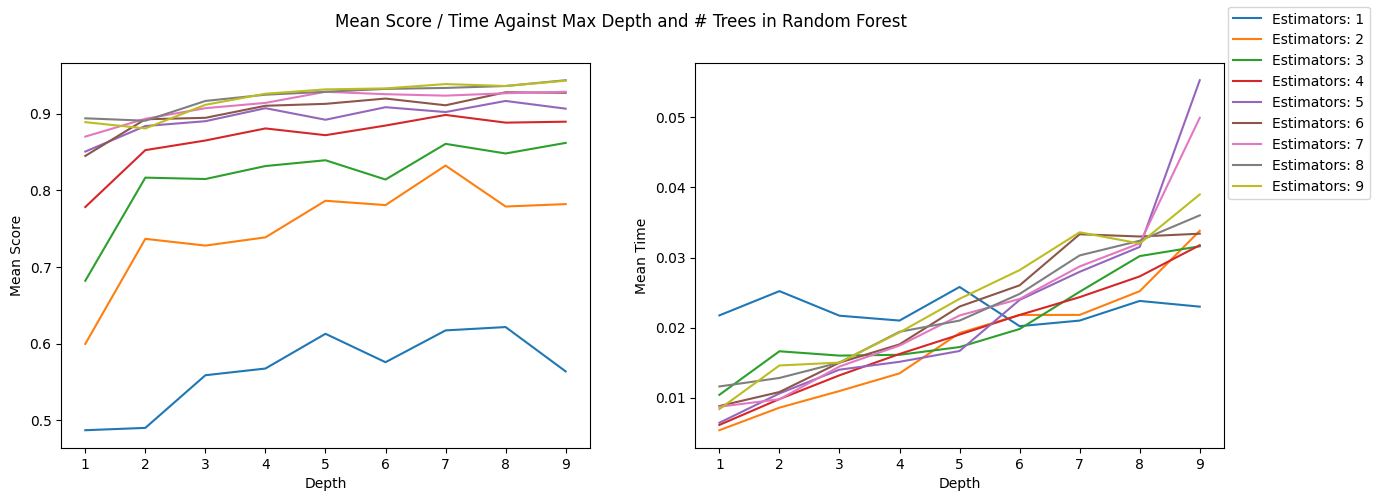

In [126]:
att = [x for x in forest_classifier_gscv.cv_results_]

scores = [x for x in forest_classifier_gscv.cv_results_['mean_test_score']]
times = [x for x in forest_classifier_gscv.cv_results_['mean_fit_time']]

scores = np.array(scores).reshape(max_estimators-1, max_depth-1)
times = np.array(times).reshape(max_estimators-1, max_depth-1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Mean Score / Time Against Max Depth and # Trees in Random Forest ')

for idx in range(1, max_estimators):
    ax1.plot(range(1, max_depth), scores[idx-1], label='Estimators: ' + str(idx))
    ax2.plot(range(1, max_depth), times[idx-1], label='Estimators: ' + str(idx))
    
ax1.set(xlabel='Depth', ylabel='Mean Score') 
ax2.set(xlabel='Depth', ylabel='Mean Time') 
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

## Thoughts
From the graphs, it seems that the score growth is logarithmic and starts to slow down around the 4-5 mark in terms of number of estimators. Where as increasing the depth only marginally increases the score, there is a high jump at the beginning and rapidly decreases increase in score. 

In terms of time, it seems that the time take to fit these models are linear both in terms of depth and number of trees in the forest

### Feature Importance

According to the random forest model, the most important feature are the knees, followed by the hips then arms then shoulders.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


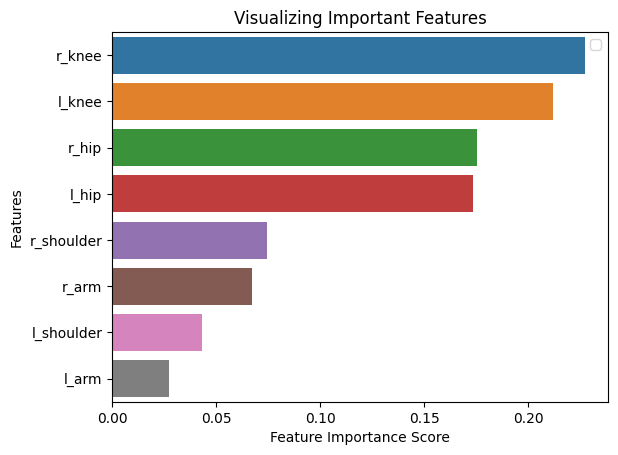

In [38]:
import seaborn as sns

feature_imp = pd.Series(best_forest.feature_importances_,index=columns[1:]).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()